In [1]:
import cv2
import numpy as np
import pywt
import time
from math import floor
import matplotlib.pyplot as plt

In [113]:
def embed(split, Q):
    # LL_1,(HL_1,LH_1,HH_1) = pywt.dwt2(np.array(LL),'haar')
#     print(split.shape)
    h, w = split.shape
#     print(floor(h/4))
    for i in range(floor(h/4)):
        for j in range(floor(w/4)):
            u,s,v = np.linalg.svd(np.float32(split[i*4:(i+1)*4,j*4:(j+1)*4]))
            s_max =int(s[0])
            a = np.mod(s_max,Q)
            if wm[i,j] == 0 and 0<=a<3*Q/4:
                s_max = s_max - a + (Q/4)
            elif wm[i,j] == 0 and 3*Q/4<=a<Q:
                s_max = s_max - a + 5*(Q/4)
            elif wm[i,j] == 255 and 0<=a<Q/4:
                s_max = s_max - a - (Q/4)
            elif wm[i,j] == 255 and Q/4<=a<Q:
                s_max = s_max - a + 3*(Q/4)   
#             s_max = s_max + Q
            s[0] = s_max
            split[i*4:(i+1)*4,j*4:(j+1)*4] = np.dot(np.dot(u,np.diag(s)),v)
#     embed_Y = pywt.idwt2((LL,(HL,LH,HH)),'haar')
    return split

In [89]:
def extract(split, Q):
    h,w = split.shape
    ex_wm =[]
    for i in range(floor(h/4)):
        for j in range(floor(w/4)):
            u,s,v = np.linalg.svd(np.float32(split[i*4:(i+1)*4,j*4:(j+1)*4]))
            s_max =(s[0])
            a = np.mod(s_max,Q)
            if a > Q/2:
                ex_wm.append(1)
            else:
                ex_wm.append(0)
    ex_wm = np.array(ex_wm).reshape((64,64))
    return ex_wm

In [99]:
def arnold(wm):
    n = 4
    a = 3
    b = 5
    size = wm.shape[0]
#     print(size)
    wm_1 = np.zeros([64,64])
    for i in range(n):
        for m in range(size):
            for n in range(size):
                x = (n+b*m)%size
                y = ((a*n)+(a*b+1)*m)%size
                wm_1[y][x] = wm[m][n]
    return wm_1

In [103]:
def arnold_rev(wm):
    n = 4
    a = 3
    b = 5
    size = wm.shape[0]
#     print(size)
    wm_1 = np.zeros([64,64])
    for i in range(n):
        for m in range(size):
            for n in range(size):
                x = ((a*b+1)*n-b*m)%size
                y = (-a*n+m)%size
                wm_1[y][x] = wm[m][n]
    return wm_1

(512, 512, 3)
加水印耗费时间: 300.99987983703613 ms


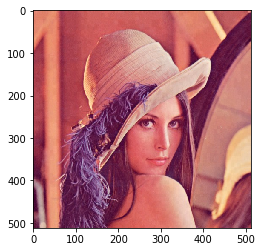

In [179]:
imgname = '1.jpg'
wmname = 'wm1.png'
q = 50 # 水印强度因子
ori_img = cv2.imread('./data/'+imgname)
img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2YCrCb)
Y_split = img[:,:,0]
print(ori_img.shape)
img1 = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
wm = cv2.imread('./data/'+wmname,cv2.IMREAD_GRAYSCALE)
outname = './output/'+'dwt_'+imgname

# wm = arnold(wm) #水印置乱

time_start=time.time() #计时
LL,(HL,LH,HH) = pywt.dwt2(np.array(Y_split),'haar')
LL = embed(LL, q)
# LH = embed(LH, q)
# HL = embed(HL, q)
# HH = embed(HH, q)
embed_Y = pywt.idwt2((LL,(HL,LH,HH)),'haar')
time_end=time.time()
print('加水印耗费时间:', (time_end - time_start)*1000,'ms')
img[:,:,0] = embed_Y
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(outname, img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

提取水印耗费时间: 310.99987030029297 ms


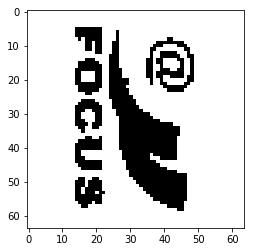

In [181]:
ex_img = cv2.imread('./output/dwt_1.jpg') 
ex_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2YCrCb) 
Y_split = ex_img[:,:,0]


# #缩小0.5倍
# Y_split = cv2.resize(Y_split,(256,256)) 
# Y_split = cv2.resize(Y_split,(512,512)) 
# #放大2倍
# Y_split = cv2.resize(Y_split,(1024,1024)) 
# Y_split = cv2.resize(Y_split,(512,512)) 

time_start=time.time() #计时

LL,(HL,LH,HH) = pywt.dwt2(np.array(Y_split),'haar')
ex_wm1 = extract(LL,q) 
# ex_wm1 = arnold_rev(ex_wm1)#水印反置乱
# ex_wm2 = extract(LH,q) 
# ex_wm3 = extract(HL,q) 
ex_wm4 = extract(HH,q)
time_end=time.time() #计时
print('提取水印耗费时间:', (time_end - time_start)*1000,'ms')
plt.imshow(ex_wm1, cmap='Greys_r') 
plt.show()